In [1]:
# Trying tf probability

from __future__ import print_function
import collections
import matplotlib.pyplot as plt
import numpy as np
import math 
import os
import pandas as pd
import scipy 
import scipy.stats

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# import tensorflow as tf
# import tensorflow.compat.v1 as tf
#tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from six.moves import urllib
import warnings
import seaborn as sns

In [2]:
# Bayesian Gaussian Mixture
# We'll use the following directory to store files we download as well as our
# preprocessed dataset.
CACHE_DIR = os.path.join(os.sep, 'tmp', 'radon')

def cache_or_download_file(cache_dir, url_base, filename):
    """Read a cached file or download it."""
    filepath = os.path.join(cache_dir, filename)
    if tf.io.gfile.exists(filepath):
        return filepath
    if not tf.io.gfile.exists(cache_dir):
        tf.io.gfile.makedirs(cache_dir)
    url = os.path.join(url_base, filename)
    print("Downloading {url} to {filepath}.".format(url = url, filepath = filepath))
    urllib.request.urlretrieve(url, filepath)
    return filepath


def download_radon_dataset(cache_dir = CACHE_DIR):
    """Download the radon dataset and read as Pandas dataframe."""
    url_base = 'http://www.stat.columbia.edu/~gelman/arm/examples/radon/'
    # Alternative source:
    # url_base = ('https://raw.githubusercontent.com/pymc-devs/uq_chapter/'
    #             'master/reference/data/')
    srrs2 = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'srrs2.dat'))
    srrs2.rename(columns = str.strip, inplace = True)
    cty = pd.read_csv(cache_or_download_file(cache_dir, url_base, 'cty.dat'))
    cty.rename(columns = str.strip, inplace=True)
    return srrs2, cty


def preprocess_radon_dataset(srrs2, cty, state = 'MN'):
    """Preprocess radon dataset as done in "Bayesian Data Analysis" book."""
    srrs2 = srrs2[srrs2.state == state].copy()
    cty = cty[cty.st == state].copy()

    # We will now join datasets on Federal Information Processing Standards
    # (FIPS) id, ie, codes that link geographic units, counties and county
    # equivalents. http://jeffgill.org/Teaching/rpqm_9.pdf
    srrs2['fips'] = 1000 * srrs2.stfips + srrs2.cntyfips
    cty['fips'] = 1000 * cty.stfips + cty.ctfips

    df = srrs2.merge(cty[['fips', 'Uppm']], on = 'fips')
    df = df.drop_duplicates(subset='idnum')
    df = df.rename(index=str, columns={'Uppm': 'uranium_ppm'})

    # For any missing or invalid activity readings, we'll use a value of `0.1`.
    df['radon'] = df.activity.apply(lambda x: x if x > 0. else 0.1)

    # Remap categories to start from 0 and end at max(category).
    county_name = sorted(df.county.unique())
    df['county'] = df.county.astype(
      pd.api.types.CategoricalDtype(categories = county_name)).cat.codes
    county_name = list(map(str.strip, county_name))

    df['log_radon'] = df['radon'].apply(np.log)
    df['log_uranium_ppm'] = df['uranium_ppm'].apply(np.log) 
    df = df[['log_radon', 'floor', 'county', 'log_uranium_ppm']]
    return df, county_name

In [3]:
radon, county_name = preprocess_radon_dataset(*download_radon_dataset())

In [4]:
radon.head()

,log_radon,floor,county,log_uranium_ppm
0,0.788457,1,0,-0.689048
1,0.788457,0,0,-0.689048
2,1.064711,0,0,-0.689048
3,0.000000,0,0,-0.689048
4,1.131402,0,1,-0.847313


In [5]:
radon.shape

(919, 4)

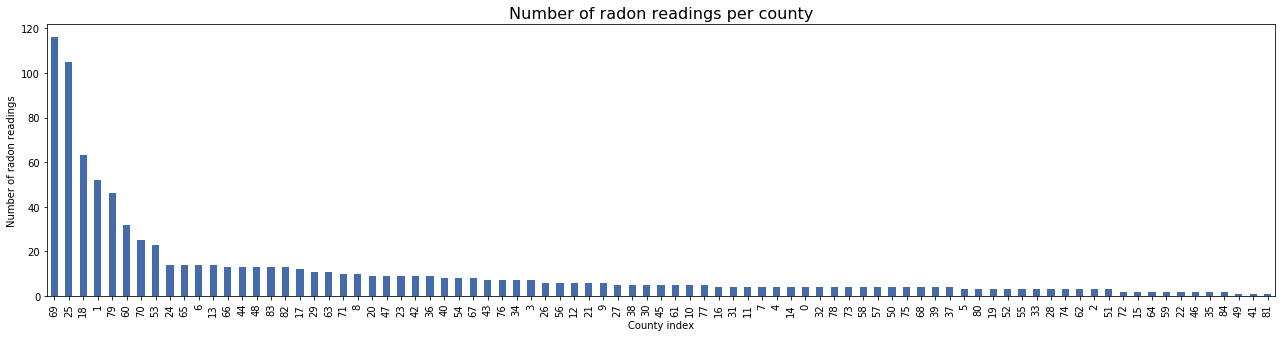

In [6]:
fig, ax = plt.subplots(figsize=(22, 5));
county_freq = radon['county'].value_counts()
county_freq.plot(kind='bar', 
                 color='#436bad');
plt.xlabel('County index')
plt.ylabel('Number of radon readings')
plt.title('Number of radon readings per county', fontsize=16)
county_freq = np.array(list(zip(county_freq.index, county_freq.values)))  # We'll use this later.

In [7]:
# Handy snippet to reset the global graph and global session.
tf.reset_default_graph()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession()

In [8]:
inv_scale_transform = lambda y: np.log(y)  # Not using TF here.
fwd_scale_transform = tf.exp

In [9]:
def _make_weights_prior(num_counties, dtype):
    """Returns a `len(log_uranium_ppm)` batch of univariate Normal."""
    raw_prior_scale = tf.get_variable(
                          name = 'raw_prior_scale',
                          initializer = np.array(inv_scale_transform(1.), 
                                                 dtype = dtype))
    return tfp.distributions.Independent(
              tfp.distributions.Normal(
                  loc = tf.zeros(num_counties, dtype = dtype),
                  scale = fwd_scale_transform(raw_prior_scale)),
                  reinterpreted_batch_ndims = 1)

make_weights_prior = tf.make_template(
                        name_='make_weights_prior', 
                        func_=_make_weights_prior)

In [10]:
def _make_log_radon_likelihood(random_effect_weights,
                               floor, 
                               county,
                               log_county_uranium_ppm, 
                               init_log_radon_stddev):
    
    raw_likelihood_scale = tf.get_variable(
                              name = 'raw_likelihood_scale',
                              initializer = np.array(
                              inv_scale_transform(init_log_radon_stddev), dtype = dtype))
    fixed_effect_weights = tf.get_variable(
                            name = 'fixed_effect_weights', 
                            initializer = np.array([0., 1.], 
                            dtype = dtype))
    fixed_effects = fixed_effect_weights[0] + fixed_effect_weights[1] * floor
    
    random_effects = tf.gather(
                              random_effect_weights * log_county_uranium_ppm,
                              indices = tf.cast(county, tf.int32),
                              axis = - 1)
    
    linear_predictor = fixed_effects + random_effects
    return tfp.distributions.Normal(
                                    loc = linear_predictor, 
                                    scale = fwd_scale_transform(raw_likelihood_scale))

make_log_radon_likelihood = tf.make_template(
                                        name_='make_log_radon_likelihood', 
                                        func_=_make_log_radon_likelihood)

In [11]:
def joint_log_prob(random_effect_weights, log_radon, floor, county,
                   log_county_uranium_ppm, dtype):
    num_counties = len(log_county_uranium_ppm)
    rv_weights = make_weights_prior(num_counties, dtype)
    rv_radon = make_log_radon_likelihood(
                              random_effect_weights,
                              floor,
                              county,
                              log_county_uranium_ppm,
                              init_log_radon_stddev = radon.log_radon.values.std())
    
    return (rv_weights.log_prob(random_effect_weights)
            + tf.reduce_sum(rv_radon.log_prob(log_radon), 
                          axis = -1)
           )

In [12]:
# Specify unnormalized posterior.
dtype = np.float32

log_county_uranium_ppm = radon[['county', 'log_uranium_ppm']].drop_duplicates().values[:, 1]
log_county_uranium_ppm = log_county_uranium_ppm.astype(dtype)

def unnormalized_posterior_log_prob(random_effect_weights):
    return joint_log_prob(
      random_effect_weights = random_effect_weights,
      log_radon = dtype(radon.log_radon.values),
      floor = dtype(radon.floor.values),
      county = np.int32(radon.county.values),
      log_county_uranium_ppm = log_county_uranium_ppm,
      dtype = dtype)

In [13]:
len(log_county_uranium_ppm)

85

In [14]:
# Set-up E-step.
# def trace_everything(states, previous_kernel_results):
#     return previous_kernel_results

#step_size = tf.constant(0.2, name = 'step_size')
step_size = tf.get_variable('step_size', initializer = np.array([0.2], dtype = np.float32), dtype = np.float32, trainable = False)
# step_size = tf.get_variable(
#             'step_size',
#             initializer = tf.Variable(0.2), #, dtype = dtype),
#             trainable = False)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = unnormalized_posterior_log_prob,
    num_leapfrog_steps = 2,
    step_size = step_size,
    store_parameters_in_results = True,
    state_gradients_are_stopped = True)

hmc = tfp.mcmc.SimpleStepSizeAdaptation(
           inner_kernel = hmc, 
           num_adaptation_steps = 20)

init_random_weights = tf.placeholder(dtype, shape = [len(log_county_uranium_ppm)])

posterior_random_weights, kernel_results = tfp.mcmc.sample_chain(
                                                num_results = 40,
                                                num_burnin_steps = 0,
                                                num_steps_between_results = 0,
                                                current_state = init_random_weights,
  #                                             trace_fn = trace_everything,
                                                kernel = hmc,
                                                )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/Users/afengler/opt/miniconda3/envs/tf-cpu/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [15]:
kernel_results.inner_results,acce

NameError: name 'acce' is not defined

In [16]:
# Set-up M-step.
loss = - tf.reduce_mean(kernel_results.inner_results.accepted_results.target_log_prob)

global_step = tf.train.get_or_create_global_step()

learning_rate = tf.train.exponential_decay(
                    learning_rate = 0.1,
                    global_step = global_step,
                    decay_steps = 2,
                    decay_rate = 0.99)

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(loss, global_step = global_step)

In [17]:
kernel_results.inner_results.accepted_results.target_log_prob

<tf.Tensor 'mcmc_sample_chain/trace_scan/TensorArrayV2Stack_2/TensorListStack:0' shape=(40,) dtype=float32>

In [18]:
# Initialize all variables.
init_op = tf.global_variables_initializer()

In [19]:
# Grab variable handles for diagnostic purposes.

with tf.variable_scope('make_weights_prior', reuse = True):
    prior_scale = fwd_scale_transform(tf.get_variable(name = 'raw_prior_scale',
                                                      dtype = dtype))

with tf.variable_scope('make_log_radon_likelihood', reuse = True):
    likelihood_scale = fwd_scale_transform(tf.get_variable(
      name = 'raw_likelihood_scale', dtype = dtype))
    fixed_effect_weights = tf.get_variable(
      name = 'fixed_effect_weights', dtype = dtype)

In [20]:
init_op.run()
w_ = np.zeros([len(log_county_uranium_ppm)], dtype = dtype)

In [ ]:
maxiter = int(500)
num_accepted = 0
num_drawn = 0
for i in range(maxiter):
    [
      _,
      global_step_,
      loss_,
      posterior_random_weights_,
      kernel_results_,
      step_size_,
      prior_scale_,
      likelihood_scale_,
      fixed_effect_weights_,
    ] = sess.run([
      train_op,
      global_step,
      loss,
      posterior_random_weights,
      kernel_results,
      step_size,
      prior_scale,
      likelihood_scale,
      fixed_effect_weights,
    ], feed_dict={init_random_weights: w_})
    
    w_ = posterior_random_weights_[-1, :]
    print(w_)
    num_accepted += kernel_results_.inner_results.is_accepted.sum()
    num_drawn += kernel_results_.inner_results.is_accepted.size
    acceptance_rate = num_accepted / num_drawn

    if i % 100 == 0 or i == maxiter - 1:
        print(prior_scale_)
        print(likelihood_scale_)
        print(global_step_)
        print(loss_.mean())
        print(acceptance_rate)
        print(step_size_)
        
        print('global_step:{:>4}  loss:{: 9.3f}  acceptance:{:.4f}  '
              'step_size:{:.4f}  prior_scale:{:.4f}  likelihood_scale:{:.4f}  '
              'fixed_effect_weights:{}'.format(
                  global_step_, loss_.mean(), acceptance_rate, step_size_[0],
                  prior_scale_, likelihood_scale_, fixed_effect_weights_))

[-0.95280945 -1.1500127  -1.303303   -0.2742938  -1.293869    2.1259534
  3.4368832   2.386616   -1.761596    0.00919881 -1.2433392   0.778656
 -2.0128849   3.206979    0.8015657  -1.2867863   0.14535369 -0.6960031
 -3.315066    1.4645202   1.9658444   1.9101679   1.3443563   4.3658547
  3.385742   -6.788536    2.0976148   0.36813554  0.22179228 -1.1604155
  2.6897764   0.08228485  1.2442533   1.6796253   0.02101508 -0.8235184
 -0.8928484  -1.8953274   2.4219613   3.0432315   2.2803173  -0.94183517
  1.3123649   0.74517787  3.402743   -0.5152155  -1.195018   -2.7224305
  2.6666498   0.09609619  2.1920457   1.9078676   0.29241207  3.1884577
 -0.52879316  0.36256534 -0.32651323  0.88256466  1.4441799   0.99451333
 -2.7481449   2.9971273   1.204175    2.1831086   0.8198955  -1.3372556
  1.5150565  -1.8573941   1.6564492  -1.6782234   4.0760345   2.9117389
  1.0388203   0.52057445 -0.976823    1.6683269   1.3013239   0.09791735
  0.08662653 -2.8449335   0.93822     1.8987428   2.0855813  -

In [21]:
%%time
posterior_random_weights_final, kernel_results_final = tfp.mcmc.sample_chain(
    num_results = int(15e3),
    num_burnin_steps = int(1e3),
    current_state = init_random_weights,
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn = unnormalized_posterior_log_prob,
    num_leapfrog_steps = 10,
    step_size = step_size))

[
    posterior_random_weights_final_,
    kernel_results_final_,
] = sess.run([
    posterior_random_weights_final,
    kernel_results_final,
], feed_dict = {init_random_weights: w_})

/Users/afengler/opt/miniconda3/envs/tf-cpu/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:336: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


CPU times: user 1min, sys: 5.66 s, total: 1min 5s
Wall time: 18.5 s


In [20]:
tfp.__version__

'0.8.0'

In [22]:
print('prior_scale: ', prior_scale_)
print('likelihood_scale: ', likelihood_scale_)
print('fixed_effect_weights: ', fixed_effect_weights_)
print('acceptance rate final: ', kernel_results_final_.is_accepted.mean())

prior_scale:  0.18830279
likelihood_scale:  0.7928577
fixed_effect_weights:  [ 1.3968102 -0.6344028]
acceptance rate final:  0.09993333333333333


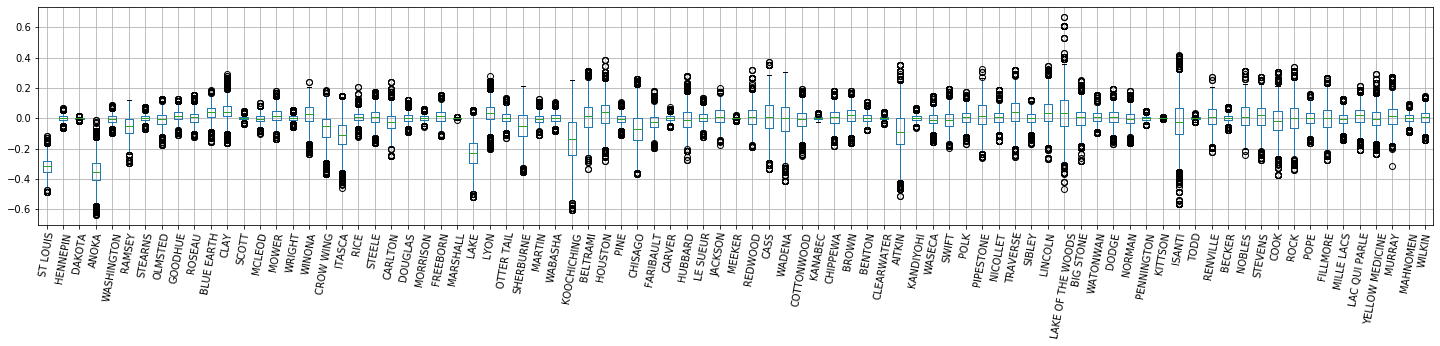

In [23]:
x = posterior_random_weights_final_ * log_county_uranium_ppm
I = county_freq[:, 0]
x = x[:, I]
cols = np.asarray(list(county_name))[I]
pw = pd.DataFrame(x)
pw.columns = cols

fig, ax = plt.subplots(figsize=(25, 4))
ax = pw.boxplot(rot = 80, vert = True);

In [50]:
np.asarray(list(county_name))

array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

In [23]:
posterior_random_weights_final_

NameError: name 'posterior_random_weights_final_' is not defined